In [338]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec, KeyedVectors
import gensim.downloader
import nltk
from tqdm import tqdm

# Gender Stereotypes in Word2Vec + Google News

We consider the word2vec word embedding, trained on text from Google News (3 million vectors), and show examples of gender stereotypes in this embedding.

The pre-trained word embedding is sourced from the `gensim` library.

In [339]:
newsvectors = gensim.downloader.load("word2vec-google-news-300")

The titular example given in the paper "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings" is shown below, where homemaker has the second-highest cosine similarity score to the analogy-generating vector.

In [340]:
vec = newsvectors["computer_programmer"] - newsvectors["man"] + newsvectors["woman"]
newsvectors.most_similar([vec])

[('computer_programmer', 0.9105811715126038),
 ('homemaker', 0.5771315693855286),
 ('schoolteacher', 0.5500192642211914),
 ('graphic_designer', 0.5464698672294617),
 ('mechanical_engineer', 0.5398366451263428),
 ('electrical_engineer', 0.5337055325508118),
 ('housewife', 0.5274525284767151),
 ('programmer', 0.5096209645271301),
 ('businesswoman', 0.5029540061950684),
 ('keypunch_operator', 0.4974639415740967)]

Some additional occupational stereotypes in this embedding include:

In [354]:
# man : surgeon :: woman : gynecologist
newsvectors.most_similar([newsvectors["surgeon"] - newsvectors["man"] + newsvectors["woman"]])

[('surgeon', 0.9068439602851868),
 ('surgeons', 0.7327114939689636),
 ('gynecologist', 0.7052876949310303),
 ('neurosurgeon', 0.7045034170150757),
 ('plastic_surgeon', 0.6821295022964478),
 ('doctor', 0.6631763577461243),
 ('Surgeon', 0.6527994871139526),
 ('orthopedic_surgeon', 0.6460433602333069),
 ('obstetrician', 0.6362589001655579),
 ('cosmetic_surgeon', 0.6331883668899536)]

In [369]:
# man : doctor :: woman : nurse
newsvectors.most_similar([newsvectors["doctor"] - newsvectors["man"] + newsvectors["woman"]])

[('doctor', 0.883492112159729),
 ('gynecologist', 0.7276508212089539),
 ('nurse', 0.6698513031005859),
 ('physician', 0.6674119830131531),
 ('doctors', 0.6649492979049683),
 ('pediatrician', 0.6398378610610962),
 ('nurse_practitioner', 0.6237460374832153),
 ('obstetrician', 0.6188927292823792),
 ('midwife', 0.6041982769966125),
 ('dentist', 0.5999661087989807)]

In [370]:
# man : dancer :: woman : ballerina
newsvectors.most_similar([newsvectors["dancer"] - newsvectors["man"] + newsvectors["woman"]])

[('dancer', 0.9194429516792297),
 ('dancers', 0.7295071482658386),
 ('ballet_dancer', 0.6663364768028259),
 ('ballerina', 0.6646263599395752),
 ('belly_dancer', 0.6396307349205017),
 ('ballroom_dancer', 0.6307015419006348),
 ('choreographer', 0.6269819736480713),
 ('dance', 0.6261250376701355),
 ('prima_ballerina', 0.6027011871337891),
 ('dancer_choreographer', 0.5955023169517517)]

I also identified a category of stereotype not discussed by the paper, adjectival stereotypes. For example,

In [371]:
# man : assertive :: woman : submissive/bossy
newsvectors.most_similar([newsvectors["assertive"] - newsvectors["man"] + newsvectors["woman"]])

[('assertive', 0.8830008506774902),
 ('assertiveness', 0.5662153363227844),
 ('forceful', 0.5302254557609558),
 ('submissive', 0.5260580778121948),
 ('assertively', 0.510796844959259),
 ('aggressive', 0.5042941570281982),
 ('bossy', 0.48802030086517334),
 ('feminine', 0.4793698489665985),
 ('demure', 0.47477802634239197),
 ('moderates_Olympia_Snowe', 0.47340264916419983)]

In [378]:
# man : boastful :: woman : flirtatious
newsvectors.most_similar([newsvectors["boastful"] - newsvectors["man"] + newsvectors["woman"]])

[('boastful', 0.8716204166412354),
 ('bragger', 0.504817545413971),
 ('conceited', 0.48360005021095276),
 ('braggart', 0.48033538460731506),
 ('brash', 0.4767358601093292),
 ('cocky', 0.47266072034835815),
 ('condescending', 0.469278484582901),
 ('bragging', 0.4673372209072113),
 ('flirtatious', 0.46674203872680664),
 ('self_aggrandizing', 0.4595392346382141)]

In [395]:
# man : disciplined :: woman : aggressive
newsvectors.most_similar([newsvectors["disciplined"] - newsvectors["man"] + newsvectors["woman"]])

[('disciplined', 0.865975558757782),
 ('discipline', 0.5209245085716248),
 ('aggressive', 0.470907598733902),
 ('diligent', 0.46397918462753296),
 ('Disciplined', 0.46364110708236694),
 ('Robbins_Gioia_combines', 0.45295968651771545),
 ('shoved_Kandji', 0.4449872076511383),
 ('Sian_Massey_suitability', 0.4368198812007904),
 ('punished', 0.43217015266418457),
 ('conscientious', 0.427097886800766)]

All of these examples above demonstrate that gender stereotypes exist in this word embedding.

## Defining the Gender Subspace

Taking inspiration from "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings," we use ten pairs of gendered words and compute the Principal Component Analysis (PCA) for the differences between their word embeddings to construct a gender subspace.

In [341]:
gender_pairs = [("she", "he"),
                ("her", "his"),
                ("woman", "man"),
                ("Mary", "John"),
                ("herself", "himself"),
                ("daughter", "son"),
                ("mother", "father"),
                ("gal", "guy"),
                ("girl", "boy"),
                ("female", "male")]

gender_diffs = [newsvectors[a] - newsvectors[b] for a, b in gender_pairs]

In [342]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(gender_diffs)

PCA(n_components=10)

The explained variance of the first component is quite high at around 60%. Thus, we are satisfied with using a single vector, defined as the "gender direction," to form the basis of the gender subspace for the embedding.

Text(0.5, 1.0, 'Explained Variance of Gender PCA')

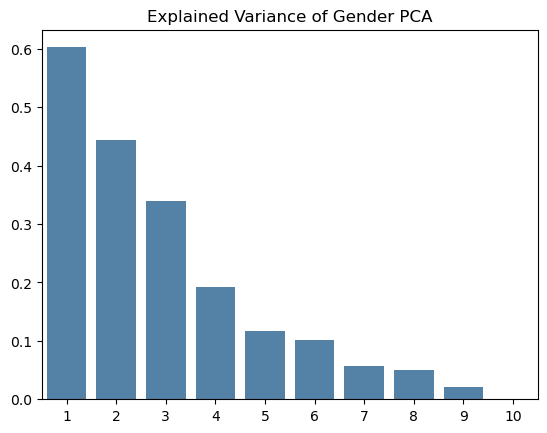

In [343]:
sns.barplot(y=pca.explained_variance_,x=list(range(1, len(pca.singular_values_) + 1)), color="steelblue")
plt.title("Explained Variance of Gender PCA")

In [344]:
gender_vec = pca.components_[0]/np.linalg.norm(pca.components_[0])

## Direct Bias

Using the gender direction defined above, we can compute the DirectBias metric as referenced in the paper to define a quantitative metric for the existence of gender stereotypes in the embedding. The DirectBias metric measures the mean cosine similarity between a collection of gender neutral words and the gender vector.

The paper uses a set of 327 occupations as the set of gender-neutral words, since their investigation focuses its examination of gender stereotypes on occupational stereotypes.

Given that I also identified a set of adjectival stereotypes (e.g. man : assertive :: woman : submissive/bossy, man : boastful :: woman : flirtatious, man : disciplined :: woman : aggressive), I chose to define the collection of gender-neutral words as a combination of gender neutral occupations (`occupations.txt`) and adjectives (`adjectives.txt`).

I created a dataset of 57 occupations and 77 adjectives. After filtering for those which did not exist in the word embedding, the final collection of gender-neutral words consists of 122 words.

In [396]:
def txt_to_array(filepath):
    with open(filepath, 'r') as file:
        # Read lines and strip newline characters, then return the list
        return [line.strip() for line in file.readlines()]
    
def cossim(x, y):
    return np.dot(x, y)/(np.linalg.norm(x) * np.linalg.norm(y))

In [346]:
occupations = txt_to_array("occupations.txt")
adjectives = txt_to_array("adjectives.txt")

gender_neutral = occupations + adjectives

In [347]:
gender_neutral_tokens = []
for w in gender_neutral:
    try:
        gender_neutral_tokens.append(newsvectors[w])
    except:
        continue

In [348]:
c = 1
gender_neutral_sim = np.array([np.abs(cossim(w, gender_vec))**c for w in gender_neutral_tokens])
direct_bias = np.sum(gender_neutral_sim)/len(gender_neutral_tokens)

Using the gender direction, the DirectBias metric for this collection of words is ~0.0586, confirming that many gender-neutural occupations and adjectives have a non-trivial component along the gender direction.

In [349]:
direct_bias

0.05864023119542275

## Hard De-Biasing

I used the hard debiasing algorithm (Neutralize) proposed in the paper and applied it to the collection of gender-neutral words. Each word was re-embedded such that
$$
\vec{w} := (\vec{w} - \vec{w}_B)/\|\vec{w} - \vec{w}_B\|
$$
where $\vec{w}_B$ is the projection of the word $\vec{w}$ onto the gender subspace.

In [350]:
def neutralize(word, g):
    proj_g = np.dot(word, g) * g
    diff = word - proj_g
    denom = np.linalg.norm(diff)
    return diff/denom

In [351]:
neutralized_tokens = [neutralize(w, gender_vec) for w in gender_neutral_tokens]

In [352]:
gender_neutral_sim_neut = np.array([np.abs(cossim(w, gender_vec))**c for w in neutralized_tokens])
direct_bias_neut = np.sum(gender_neutral_sim_neut)/len(gender_neutral_tokens)

After neutralizing these words, the DirectBias score is substantially decreased and very close to 0.

In [353]:
print(direct_bias_neut)

1.4158613944294313e-17
